# **Neural Networks Validation**

## Neural Network using Pytorch

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

#1. Load the data

In [ ]:
"""Define Transform to Normalize the Data & Apply the Transform to a DataSet"""
#data_dir = 'Cat_Dog_data'
### Defining Transform to Normalize the Data **********************
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5),
                                                     (0.5))
                                ])
### Then Downloa and apply this Transform to your dataset *********************
### Pass transforms in here, then run the next cell to see how the transforms look
#train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms);
test_data = datasets.MNIST(root = "./data", train= False, download=True, transform=train_transforms)

In [3]:
###  Load the training & test data and set the batch size **********************
trainloader= torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
data_iter = iter(testloader)
images,labels = next(data_iter)

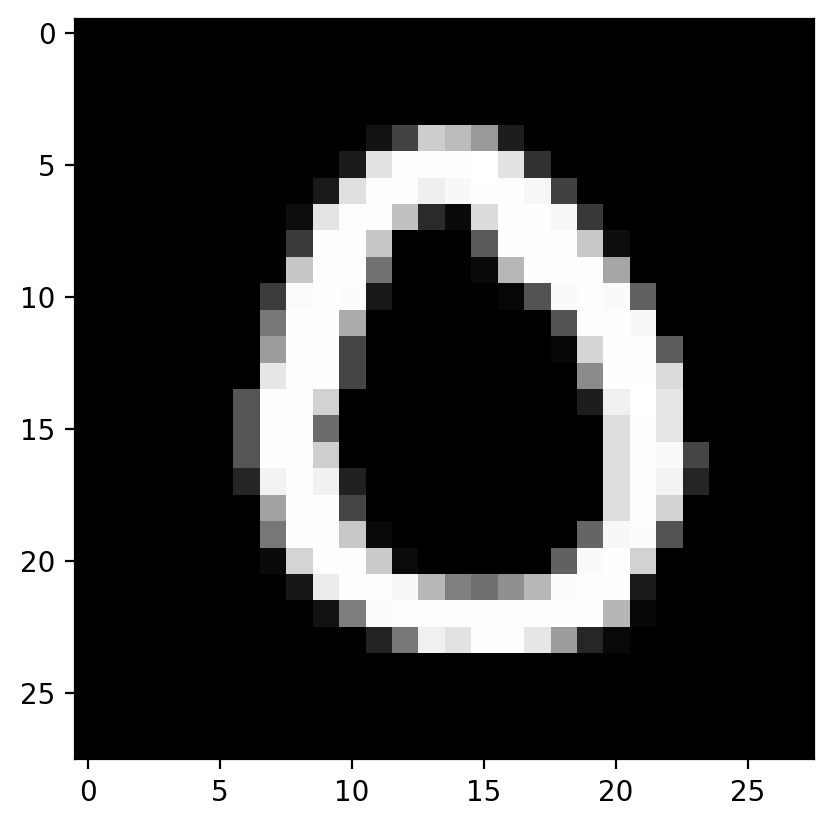

In [4]:
# Select one image from the batch and display
selected_image = images[10]
# Display the image
plt.imshow(selected_image.numpy().squeeze(), cmap='Greys_r')

#2. Build the Network: Using MLP Module and Dropout

In [5]:
## Neural Network: Object Class
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    ## fully-connected layer "fc"
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    ## Define the functions
    self.ReLU = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

    ## Dropout Module with 0.2 Probability
    self.dropout = nn.Dropout(p=0.2)

  ## Define forward Method
  def forward(self, y):
    y = self.dropout(F.relu(self.fc1(y)))
    y = self.dropout(F.relu(self.fc2(y)))
    y = self.dropout(F.relu(self.fc3(y)))
    # output so no dropout here
    y = F.log_softmax(self.fc4(y), dim=1)
    return y

## Pick up a manual seed for randomization
torch.manual_seed(41)
classifier1 = Network()

##2.1 Use a GPU if available

In [6]:
## Use a GPU if available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('GPU is not available, tain on Cpu')
else:
  print('GPU is available, train on GPU ...')

GPU is not available, tain on Cpu


#3. Set the Criterion and Optimizer of the Model

In [9]:
from torch import optim
## Define the Loss function: NLLLoss()
Criterion = nn.NLLLoss()
## Optimizers require the parameters to optimize and a learning rate
# Optimizer Function: Adam
optimizer = optim.Adam(classifier1.parameters(), lr = 0.003)
## Move the classifier Model to CUDA/GPU
if train_on_gpu:
  classifier1.cuda()

#4. Start the Training: using for Loop

- Forward pass
- Zero grad

- Calculate the loss

- Back propagation
- Optimizer Step

In [10]:
## Train Loop
epochs = 10
train_losses, test_losses = [], []
for ee in range(epochs):
  running_loss = 0
  for image, label in trainloader:
    ## Flattern the input data
    inputs = images.view(images.shape[0], -1)
    ## Prediction values - train_data
    y_pred = classifier1.forward(inputs)          # forward Pass********
    ## Probability
    proba = torch.exp(y_pred)

    #Zero grad
    optimizer.zero_grad()
    ## loss/error calculation
    loss = Criterion(y_pred, labels)

    ## Total loss
    running_loss += loss.item()
    ## back Propagation
    loss.backward()
    ## Update the steps
    optimizer.step()

    ## Avg train loss
    train_loss = running_loss / len(trainloader.dataset)
    train_losses.append(train_loss)

  else:
    tot_testloss = 0
    test_correct = 0    # Number of correct Predictions
    #print(loss)

In [ ]:
print(train_losses)

In [10]:
#top_p, top_class = proba.topk(1, dim =1)
#print(top_class[:2, :])

To check if the predicted classes match the labels.
We simply to do it by equating `top_class` and ``labels``, but we have to be careful of the shapes. Here top_class is a 2D tensor with shape (64, 1) while labels is 1D with shape (64)

In [11]:
#print(top_class.shape), print(labels.shape)

To get the equality to work out the way we want, top_class and labels must have the same shape.

In [12]:
#equals = top_class == labels
#print(equals.shape)

#5. Compute the Model Validation, the prediction on Test Dataset

In [17]:
## Turn off Gradient for Validation
epochs = 5
for ee in range(epochs):

  with torch.no_grad():
    classifier1.eval()
    # Evaluate
    for img, lab in testloader:
      input = images.view(images.shape[0], -1)

      predict = classifier1.forward(input)
      loss_1 = Criterion(predict, labels)
      tot_testloss += loss_1.item()

      ps = torch.exp(predict)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)

      test_correct += equals.sum().item()

    ## Avag test loss
    test_loss = tot_testloss / len(testloader)
    test_losses.append(tot_testloss)
    print(f'Test loss: {test_losses}')

Test loss: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test loss: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test loss: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test loss: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Test loss: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
print("Epoch: {}/{}.. ".format(ee+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[2]),
              "Test Loss: {:.3f}.. ".format(test_losses[2]),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 5/5..  Training Loss: 0.000..  Test Loss: 0.000..  Test Accuracy: 5.024


# 6. Model Accuracy

In [14]:
accuracy1 = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy: {accuracy1.item()*100} %")

Accuracy: 100.0 %


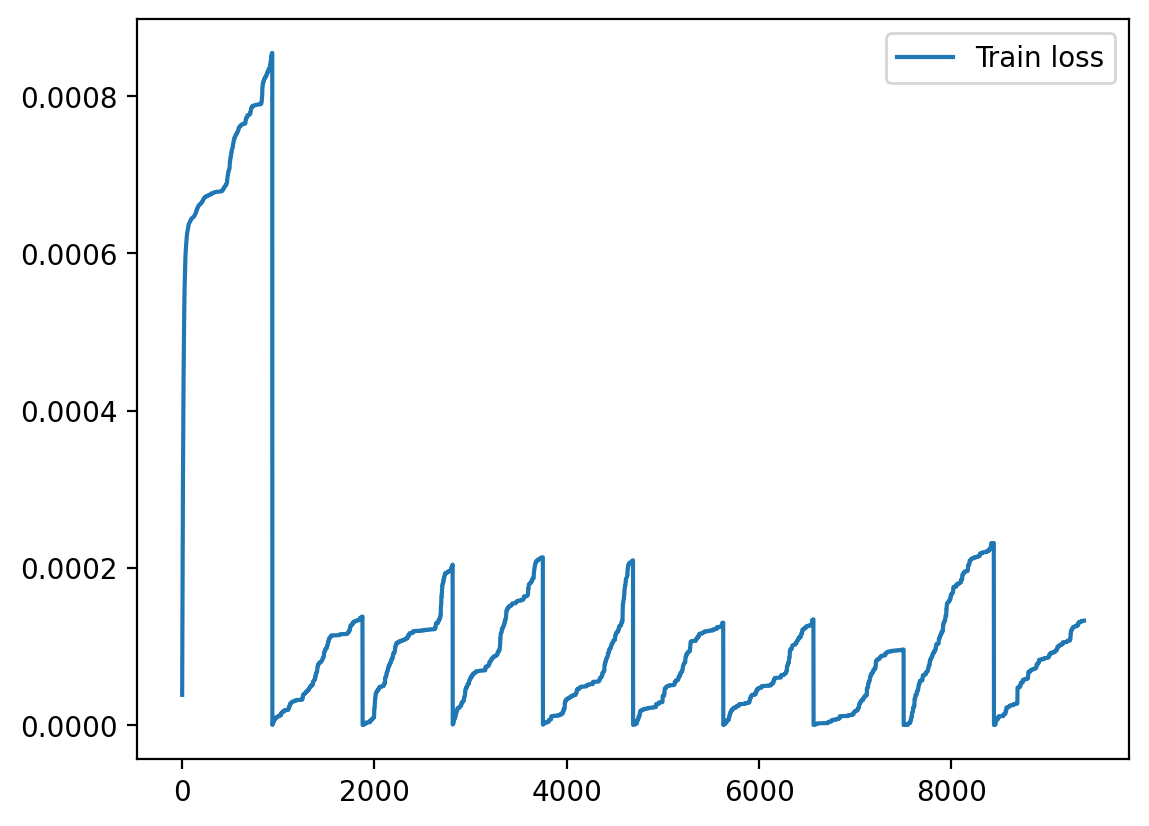

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot(train_losses, label = 'Train loss')

#plt.plot(test_losses, label = 'Test loss')
plt.legend()
plt.show()

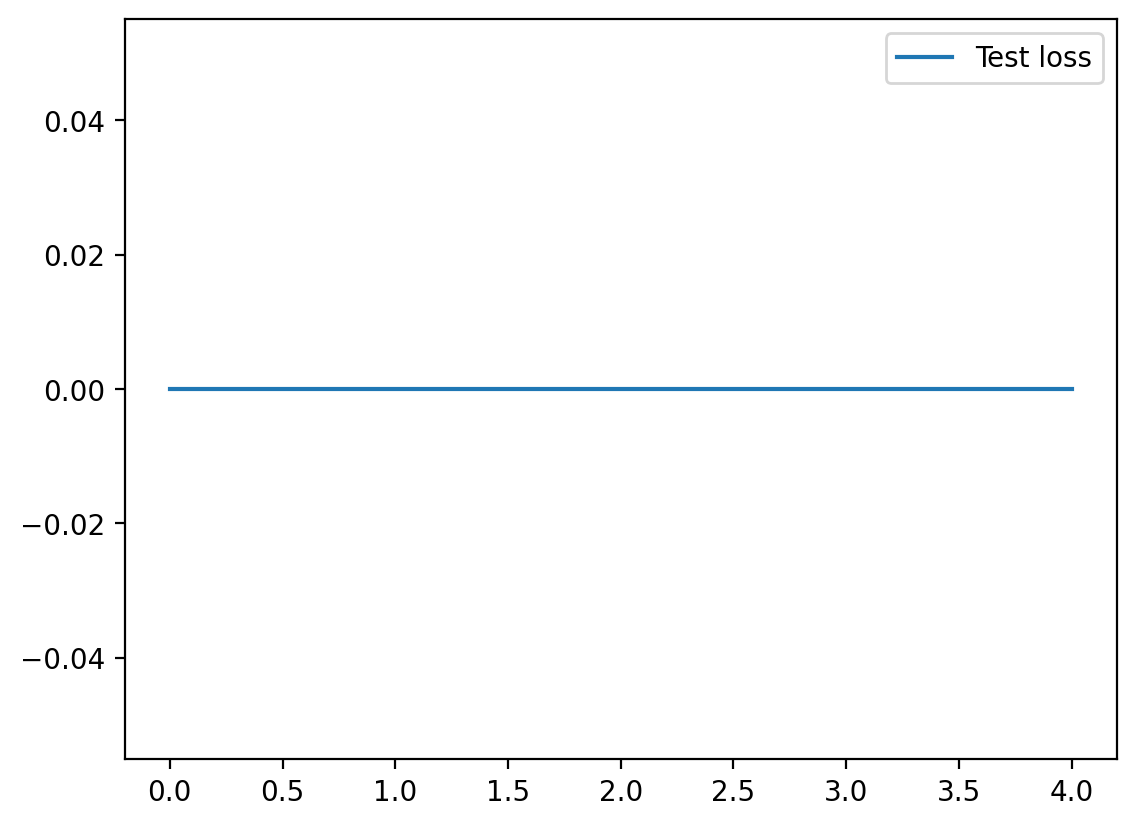

In [16]:
plt.plot(test_losses, label = 'Test loss')
plt.legend()
plt.show()

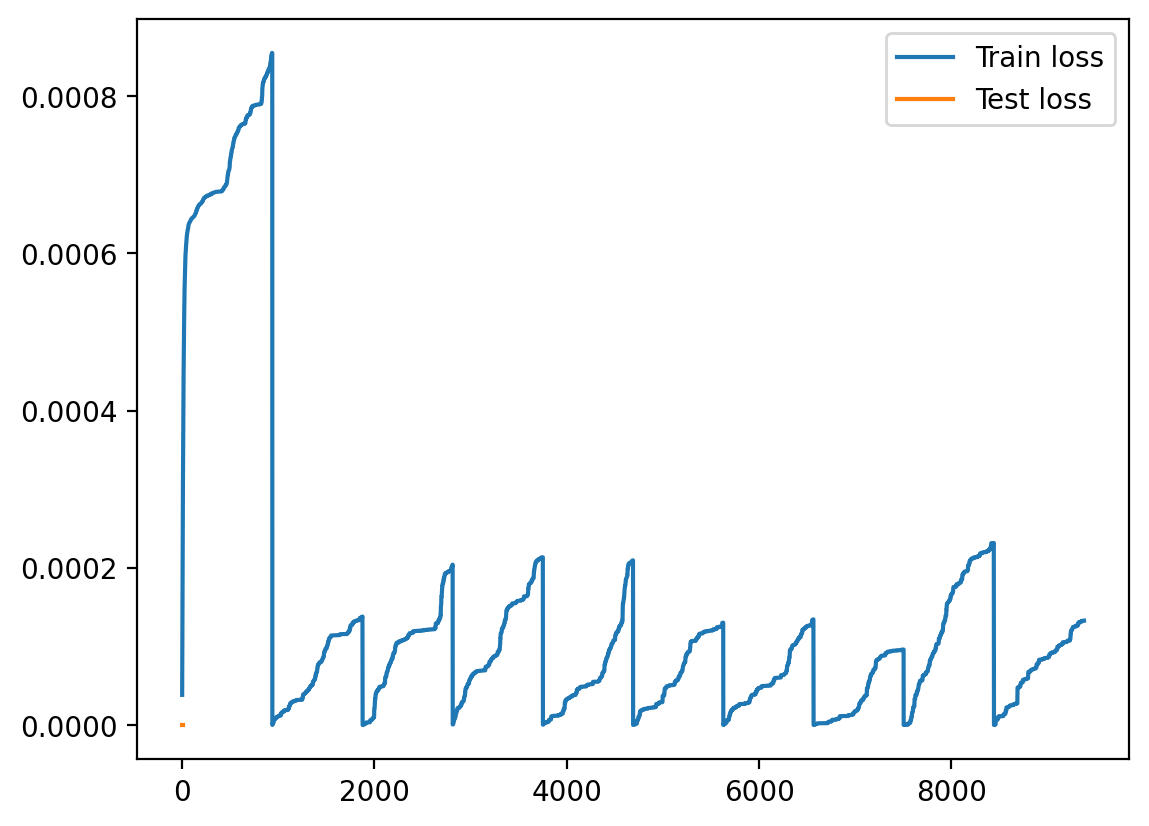

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot(train_losses, label = 'Train loss')

plt.plot(test_losses, label = 'Test loss')
plt.legend()
plt.show()

##Remarks:
The use of Dropout and Log_Softmax() function have helped to improve the performance of the Neural Network.